<a href="https://colab.research.google.com/github/inders/AISenseiCommunity-Knowledge/blob/main/Transfomers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [238]:
# prompt: impor torch and numpy and nn from torch
import torch
import numpy as np
from torch import nn


In [239]:
# prompt: Generate numpy code to generate a 3d tensor of size 6*4*64 and print it

import numpy as np

# Generate a 3d tensor of size 6*4*64
tensor = np.random.rand(6, 4, 64)

# Print the tensor
print(tensor)


[[[7.14101931e-01 1.11760753e-01 4.99102467e-01 ... 1.41948710e-01
   1.87770477e-01 6.29673748e-01]
  [1.75024436e-01 8.29456902e-01 6.48887147e-01 ... 2.58592098e-01
   9.87209896e-01 7.67003407e-01]
  [2.62325921e-01 3.35575205e-01 4.59876801e-01 ... 4.58034249e-01
   9.61076202e-01 6.12209895e-01]
  [1.60577122e-01 3.89155922e-02 5.73901295e-01 ... 2.36059844e-01
   4.41451953e-01 5.53332252e-01]]

 [[8.76339351e-01 6.01233772e-01 2.50704670e-01 ... 6.11644455e-01
   1.24091215e-01 8.31969313e-01]
  [2.74196014e-02 7.12866981e-01 2.54105611e-01 ... 6.08156697e-01
   5.22156349e-01 3.20224088e-02]
  [2.52097724e-01 6.05884629e-01 1.95757656e-01 ... 8.85370071e-01
   2.52413545e-01 3.31830553e-01]
  [6.32201277e-01 6.26085630e-01 2.96539557e-01 ... 9.37540972e-01
   3.16446883e-02 1.70193277e-01]]

 [[9.57553925e-01 3.51892133e-01 2.49324752e-01 ... 7.16171494e-01
   2.77308005e-01 8.43499296e-01]
  [1.83911104e-01 4.52842746e-01 3.44804611e-01 ... 7.35468426e-01
   7.64688081e-01 2.

In [240]:
# prompt: split this tensor axis into 2 parts on axis=-1

# Split the tensor into two parts along the last axis
X1, X2 = np.split(tensor, 2, axis=-1)

#print original shape
print('X shape', tensor.shape)
print(tensor)

# Print the first part
print('*******')
print('X1 shape', X1.shape)
print(X1)


# Print the second part
print('*******')
print('X2 shape', X2.shape)
print(X2)


X shape (6, 4, 64)
[[[7.14101931e-01 1.11760753e-01 4.99102467e-01 ... 1.41948710e-01
   1.87770477e-01 6.29673748e-01]
  [1.75024436e-01 8.29456902e-01 6.48887147e-01 ... 2.58592098e-01
   9.87209896e-01 7.67003407e-01]
  [2.62325921e-01 3.35575205e-01 4.59876801e-01 ... 4.58034249e-01
   9.61076202e-01 6.12209895e-01]
  [1.60577122e-01 3.89155922e-02 5.73901295e-01 ... 2.36059844e-01
   4.41451953e-01 5.53332252e-01]]

 [[8.76339351e-01 6.01233772e-01 2.50704670e-01 ... 6.11644455e-01
   1.24091215e-01 8.31969313e-01]
  [2.74196014e-02 7.12866981e-01 2.54105611e-01 ... 6.08156697e-01
   5.22156349e-01 3.20224088e-02]
  [2.52097724e-01 6.05884629e-01 1.95757656e-01 ... 8.85370071e-01
   2.52413545e-01 3.31830553e-01]
  [6.32201277e-01 6.26085630e-01 2.96539557e-01 ... 9.37540972e-01
   3.16446883e-02 1.70193277e-01]]

 [[9.57553925e-01 3.51892133e-01 2.49324752e-01 ... 7.16171494e-01
   2.77308005e-01 8.43499296e-01]
  [1.83911104e-01 4.52842746e-01 3.44804611e-01 ... 7.35468426e-01
 

In [241]:
# prompt: generate code to learn about swapaxis function of numpy on the same input tensor

# Use the swapaxes function to swap the first and last axes of the tensor
swapped_tensor = np.swapaxes(tensor, -1, -2)

# Print the swapped tensor
print('*******')
print('Swapped Tensor shape', swapped_tensor.shape)
print(swapped_tensor)

*******
Swapped Tensor shape (6, 64, 4)
[[[7.14101931e-01 1.75024436e-01 2.62325921e-01 1.60577122e-01]
  [1.11760753e-01 8.29456902e-01 3.35575205e-01 3.89155922e-02]
  [4.99102467e-01 6.48887147e-01 4.59876801e-01 5.73901295e-01]
  ...
  [1.41948710e-01 2.58592098e-01 4.58034249e-01 2.36059844e-01]
  [1.87770477e-01 9.87209896e-01 9.61076202e-01 4.41451953e-01]
  [6.29673748e-01 7.67003407e-01 6.12209895e-01 5.53332252e-01]]

 [[8.76339351e-01 2.74196014e-02 2.52097724e-01 6.32201277e-01]
  [6.01233772e-01 7.12866981e-01 6.05884629e-01 6.26085630e-01]
  [2.50704670e-01 2.54105611e-01 1.95757656e-01 2.96539557e-01]
  ...
  [6.11644455e-01 6.08156697e-01 8.85370071e-01 9.37540972e-01]
  [1.24091215e-01 5.22156349e-01 2.52413545e-01 3.16446883e-02]
  [8.31969313e-01 3.20224088e-02 3.31830553e-01 1.70193277e-01]]

 [[9.57553925e-01 1.83911104e-01 7.65270476e-02 5.12182066e-01]
  [3.51892133e-01 4.52842746e-01 5.89986139e-01 3.35580622e-01]
  [2.49324752e-01 3.44804611e-01 8.30893525e-01 

In [242]:
# prompt: import numpy package



In [243]:
# prompt: generate a function to check an input array is numpy array or not

def is_numpy_array(input_array):
  return isinstance(input_array, np.ndarray)


In [244]:
# To impelement attention as referenced and explained in my memo here - https://www.linkedin.com/pulse/intuition-nuts-bolts-transformers-explained-visually-inder-singh-aarge/?trackingId=KjnvXjXdR4isgE2ZqkwNRg%3D%3D
# we need to implement the following equation
# y = softmax (1/SQRT(d) (K @ Q^T)) @ V
# K = x @ Wk
# Q = x @ Wq
# V = x @ Wv


In [245]:
# prompt: generate a function to generate softmax in numpy
# Given X, return softmax of X
def softmax(x):
  """Compute softmax values for each sets of scores in x."""
  #Why do we use axis=-1?
  #We want to calculate softmax for each tensor and tensors are represented as columns.
  #The last dimension reflects the same
  tensorColumnDimension = -1
  print("Inside softmax: x is numparray", is_numpy_array(x))
  e_x = np.exp(x - x.max(axis=tensorColumnDimension, keepdims=True))
  # Use axis=-1 when you want to work on the last dimension
  #keepdims=True will retain the tensor shape even if it returns a 1d arrary from a
  #2d array by making the first dimension the channel
  return e_x / e_x.sum(axis=tensorColumnDimension, keepdims=True)


In [246]:
#Implement attention
#Remember from block[3], we want to implement Q, K, V which are three matrix multiplications as outlined[3]
#Instead of doing three seperate matrix multiplications, we can do them in one shot
#[K Q V] can be a matrix of 3xNx64(it has three channels for K, Q, V and each channel has a Nx64 matrix where N is number of
#rows in the input)
#Similarily [Wk Wq Wv] can reperesented as one matrix of 3x512x64(it has three channels for Wk, Wq, Wv and each channel has
#512*64 matrix which is the weight matrix)

def attention(X, mask, W_KQV, W_Out):
  #mulitply X with Wk, Wq, Wv and split it into three matrices
  #Why does the following code work for both batched and non-batched cases?
  #In non-batched case X = [sequence length, num_dimensions_per_word]eg:[4, 6] and let's say W_QKV = [6, 9] where 3 columns
  #represent each Q, K and V matrices
  #After multiplication, we will get [4, 9] and splitting that into three parts on last dimension will give us three
  #[4, 3] tensors
  #For a batched example
  #X = [ batch_size, sequence_length, num_dimensions_per_word]eg: [5, 4, 6] and let's say W_QKV = [6, 9] where Q, K, V are
  #merged as 3 columns. After the multiplication the resulting tensor will be [5, 4, 9] and splitting it on last dimension
  #will give three matrices of [5, 4, 3]. Each of these will have 5 batches of 4 sequence length, each with dimension_size of
  #3
  print("Inside attention: X shape=", X.shape)
  print("Inside attention: W_KQV shape=", W_KQV.shape)
  K, Q, V = np.split(X @ W_KQV, 3, axis=-1)
  print("Inside attention: K shape=", K.shape)
  print("Inside attention: Q shape=", Q.shape)
  print("Inside attention: V shape=", V.shape)
  print("Inside attention: mask shape=", mask.shape)
  # x.shape[-1] will give the number of columns in the tensor that is txd where t is sequence length and d
  # is the number of dimensions in the vector
  # we normalize the attention matrix KxQ^T by the square root of d
  # why normalizing on X.shape(-1) works for both batched and non-batched use-cases?
  # As an example X can be [5, 9]txd for non-batch. In this case tensors are arranged by column so d=9
  # When X is batched like [B, t, d] or [ 4, 5, 9] then also normalising on last dimension i.e. 9 is the right thing to do
  print("Inside attention:X.shape[-1]=", X.shape[-1])
  norm_dim = np.sqrt(X.shape[-1])
  #How to do K @ Q^T so that it always works. Replace last two axis to do transpose on batch and non-batch matrices.
  attn_matrix = K @ Q.swapaxes(-1, -2) /norm_dim + mask
  print("Inside attention: attn_matrix shape=", attn_matrix.shape)
  attn = softmax(attn_matrix)
  #In many implementations, this result is then passed through another linear transformation using W_out to obtain the final
  #output of the self-attention layer. This step allows the network to potentially learn a more complex transformation of the
  #attention-weighted values.
  Y = attn @ V @ W_Out
  return Y, attn






In [247]:
import torch
tensor = torch.randn(3, 3)
print(tensor)
print('Upper triangular matrix with diagonal')
print(torch.triu(tensor, diagonal=0))
print('Upper triangular matrix without diagonal')
print(torch.triu(tensor, diagonal=1))

tensor([[-0.3181, -0.7400,  0.6083],
        [ 1.8425, -1.1629,  0.5129],
        [-0.7709, -0.0261,  0.4186]])
Upper triangular matrix with diagonal
tensor([[-0.3181, -0.7400,  0.6083],
        [ 0.0000, -1.1629,  0.5129],
        [ 0.0000,  0.0000,  0.4186]])
Upper triangular matrix without diagonal
tensor([[ 0.0000, -0.7400,  0.6083],
        [ 0.0000,  0.0000,  0.5129],
        [ 0.0000,  0.0000,  0.0000]])


In [248]:
# Parameters
embed_dim = 512  # Embedding dimension
num_heads = 1   # Number of heads, set to 1 for single-head attention
seq_len = 10    # Sequence length
batch_size = 4  # Batch size

#Attention matrix is [seq_len, seq_len] so we need create mask of the same dimensions
#with negative infinity in upper diagonal part of matrix and zeros in lower diagonal part of matrix
mask = torch.triu(-float("inf") * torch.ones(seq_len, seq_len), diagonal=1).detach()
print("mask shape=", mask.shape)


mask shape= torch.Size([10, 10])


In [249]:
import torch
import torch.nn as nn


# Initialize MultiheadAttention module
multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)

# Example input data (query, key, value)
# Note: PyTorch's MultiheadAttention expects input in the shape of [seq_len, batch_size, embed_dim]
#query = torch.rand(seq_len, batch_size, embed_dim)
#key = torch.rand(seq_len, batch_size, embed_dim)
#value = torch.rand(seq_len, batch_size, embed_dim)
X = torch.rand(seq_len, batch_size, embed_dim)

# Apply the attention mechanism. Since we
# attn_output: the output of the attention mechanism
# attn_output_weights: the weights of the attention mechanism
#In PyTorch, when using the MultiheadAttention module to calculate multi-head attention,
#you can pass the same tensor as the query (Q), key (K), and value (V) inputs if you want
#the module to compute Q, K, and V from the same source data. This approach is common in
#self-attention mechanisms within Transformer models, where the input sequence to an encoder
#or a decoder layer serves as Q, K, and V.
print("MultiHeadAttention X shape=", X.shape)
attn_output, attn_output_weights = multihead_attn(query=X, key=X, value=X, attn_mask=mask)

print("Attention Output Shape:", attn_output.shape)
print("Attention Weights Shape:", attn_output_weights.shape)

#print("Attention Output = ", attn_output)




MultiHeadAttention X shape= torch.Size([10, 4, 512])
Attention Output Shape: torch.Size([10, 4, 512])
Attention Weights Shape: torch.Size([4, 10, 10])


In [250]:
#Let's compute our numpy based attention on the same X, Q, K and V and compare if the output matrices are identical

#reshape X from seq_len, batch_size, embed_dim to batch_size_seq_len, batch_size for our numpy impelmentation
print("X shape", X.shape)
x_numpy = X.permute(1, 0, 2).detach().numpy()
W_KQV_numpy = multihead_attn.in_proj_weight.detach().numpy()
W_out_numpy = multihead_attn.out_proj.weight.detach().numpy()

print("X_numpy shape", x_numpy.shape)
print("Mask shape", mask.shape)
print("W_KQKV shape", W_KQV_numpy.shape)
print("W_out shape", W_out_numpy.shape)



X shape torch.Size([10, 4, 512])
X_numpy shape (4, 10, 512)
Mask shape torch.Size([10, 10])
W_KQKV shape (1536, 512)
W_out shape (512, 512)


In [251]:
#reshape WQKV so that it can be multiplied by X inside the function
W_KQV_t = W_KQV_numpy.transpose()
W_out_t = W_out_numpy.transpose()
print("W_KQV reshaped size=",W_KQV_t.shape)
print("W_out reshaped size=", W_out_t.shape)
mask_numpy = mask.numpy()
Y, A = attention(x_numpy, mask_numpy, W_KQV_t, W_out_t)
print("numpy attention output shape=", Y.shape)
print("numpy attention weights output shape=", A.shape)
print("Attention Output Shape:", attn_output.shape)
print("Attention Weights Shape:", attn_output_weights.shape)


W_KQV reshaped size= (512, 1536)
W_out reshaped size= (512, 512)
Inside attention: X shape= (4, 10, 512)
Inside attention: W_KQV shape= (512, 1536)
Inside attention: K shape= (4, 10, 512)
Inside attention: Q shape= (4, 10, 512)
Inside attention: V shape= (4, 10, 512)
Inside attention: mask shape= (10, 10)
Inside attention:X.shape[-1]= 512
Inside attention: attn_matrix shape= (4, 10, 10)
Inside softmax: x is numparray True
numpy attention output shape= (4, 10, 512)
numpy attention weights output shape= (4, 10, 10)
Attention Output Shape: torch.Size([10, 4, 512])
Attention Weights Shape: torch.Size([4, 10, 10])


In [252]:
#Let's reshape attn_output_shape from [seq_len, batch_size, embed_dim] to [batch_size, seq_len, embed_dim]
multihead_attn_output_numpy = attn_output.permute(1, 0, 2).detach().numpy()
print("multihead_attn_output_numpy shape=", multihead_attn_output_numpy.shape)
#Let's compute the difference between the output of pytorch and out numpy attention blocks
print("Difference in attention output=", np.linalg.norm(Y - multihead_attn_output_numpy))
print("Difference in attention matrix=", np.linalg.norm(A - attn_output_weights.detach().numpy()))

multihead_attn_output_numpy shape= (4, 10, 512)
Difference in attention output= 1.1882678e-05
Difference in attention matrix= 2.7007712e-07


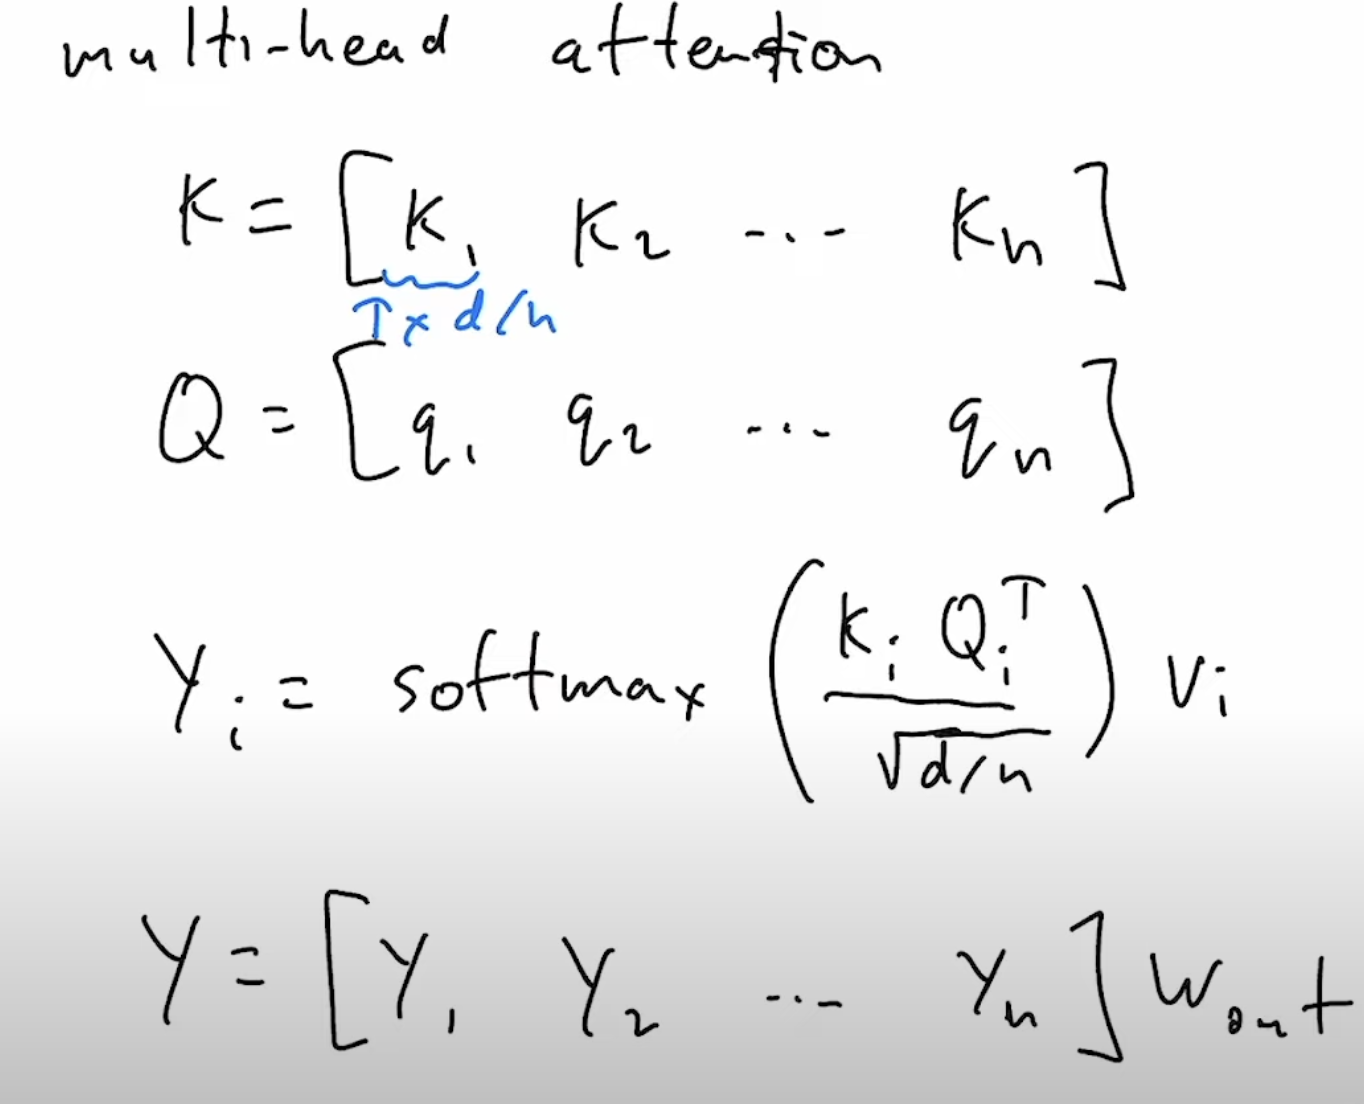

In [253]:
#Let's implement multi-head attention
#As shown in the picture below and in the original memo multihead attention is impelmented by having
#different K,Q and V matrices for each head. Caluclating attention for each head seperately and projecting on V
# and then concatenating them together as shown in the picture above

# To implement this, K, Q and V will become from Txd(embed_dim) matrix to Txdxh
# where h represents the number of heads. The vectors of all heads of K, Q, V are concatenated together
# To do this in batches we have to convert this into BxHxTxD so that we have all heads of a single batch together
# and within each head their TxD matrices

def numpy_multi_head_attention(X, W_KQV, mask, num_heads, W_out):
  B, T, d = X.shape
  K, Q, V = np.split(X @ W_KQV, 3, axis=-1)
  # we have to convert K, Q, V from BxTxD to BxHxTxd
  head_axis = 2
  t_axis = 1
  #The multiple heads of K, Q, V are contained as a large matrix such that all heads of K are in the vector of K
  # and so on. This is why when we divide K, Q, V by num_heads, we will get a shape of BxTxnum_headsxd
  # and swapping axis 1 and 2 will give us Bxnum_headsxTxd which is the right shape
  K = K.reshape(B, T, num_heads, d // num_heads).swapaxes(t_axis, head_axis)
  Q = Q.reshape(B, T, num_heads, d // num_heads).swapaxes(t_axis, head_axis)
  V = V.reshape(B, T, num_heads, d // num_heads).swapaxes(t_axis, head_axis)

  #Let's calculate attention
  # Single head attention code was -attn_matrix = K @ Q.swapaxes(-1, -2) /norm_dim + mask
  # Remember that K, Q, V are Bxnum_headsxTxD so for we transpose Q below
  # d is combined shape of initially stacked up K, Q, V as shown in first line of this function
  # we need to divide it by num_heads to get real D(embed_dim)
  scaled_dot_product  = K @ Q.swapaxes(-1, -2) // np.sqrt(d // num_heads)
  print("Inside numpy_multi_head_attention BATCH mode: scaled_dot_product shape, is NumpyArray ",
        scaled_dot_product.shape, is_numpy_array(scaled_dot_product))
  print("Inside numpy_multi_head_attention BATCH mode: mask shape, isNumPyArray ", mask.shape,
        is_numpy_array(mask))

  attn = scaled_dot_product + mask
  attn_matrix = softmax(attn)
  #attn_matrix is of shape Bxnum_headsxTxT produced by multiplying Bxnum_headsxTxd into Bxnum_headsxdXT
  #V matrix is of shape Bxnum_headsxTxd
  #attn @ V should be Bxnum_headsxTxd
  #We want it to convert it back to BxTxnum_headsXd before getting to B, T, D
  #(inversing what we did to get K, Q, V)
  #We achieve this through swapaxes and then reshape below
  Y = (attn_matrix @ V).swapaxes(1, 2).reshape(B, T, d) @ W_out
  return Y, attn_matrix








In [254]:
#Let's test multi-head attention by changing num_heads to 4
#Let's find our ground truth using pytorch multihead attention
num_heads = 4
batch_multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, bias=False, batch_first=True)
print("BATCH MultiHeadAttention X shape=", X.shape)
print("X should not be a numpy array = ",is_numpy_array(X))

#Reshape X from seq_len, batch_size, embed_dim to batch_size, seq_len, embed_dim when batch_first=True
X = X.permute(1, 0, 2)
print("BATCH MultiHeadAttention X shape=", X.shape)

Y_, A_ = batch_multihead_attn(query=X, key=X, value=X, attn_mask=mask)

print("Attention Output Shape:", Y_.shape)
print("Attention Weights Shape:", A_.shape)



BATCH MultiHeadAttention X shape= torch.Size([10, 4, 512])
X should not be a numpy array =  False
BATCH MultiHeadAttention X shape= torch.Size([4, 10, 512])
Attention Output Shape: torch.Size([4, 10, 512])
Attention Weights Shape: torch.Size([4, 10, 10])


In [255]:
#Let's calculate actuals using out NUMPY implementation
#reshape X from seq_len, batch_size, embed_dim to batch_size_seq_len, batch_size for our numpy impelmentation
print("X shape", X.shape)
x_numpy = X.detach().numpy()
W_KQV_numpy = batch_multihead_attn.in_proj_weight.detach().numpy()
W_out_numpy = batch_multihead_attn.out_proj.weight.detach().numpy()

print("X_numpy shape", x_numpy.shape)
print("Mask shape", mask.shape)
print("W_KQKV shape", W_KQV_numpy.shape)
print("W_out shape", W_out_numpy.shape)

#reshape WQKV so that it can be multiplied by X inside the function
W_KQV_t = W_KQV_numpy.transpose()
W_out_t = W_out_numpy.transpose()
print("W_KQV reshaped size=",W_KQV_t.shape)
print("W_out reshaped size=", W_out_t.shape)
mask_numpy = mask.numpy()



X shape torch.Size([4, 10, 512])
X_numpy shape (4, 10, 512)
Mask shape torch.Size([10, 10])
W_KQKV shape (1536, 512)
W_out shape (512, 512)
W_KQV reshaped size= (512, 1536)
W_out reshaped size= (512, 512)


In [256]:
Y_numpy, A_numpy = numpy_multi_head_attention(X=x_numpy, W_KQV=W_KQV_t, mask=mask_numpy, W_out=W_out_t, num_heads=num_heads)

print("numpy_multi_head_attention Y shape =", Y_numpy.shape)
print("numpy_multi_head_attention A shape =", A_numpy.shape)


Inside numpy_multi_head_attention BATCH mode: scaled_dot_product shape, is NumpyArray  (4, 4, 10, 10) True
Inside numpy_multi_head_attention BATCH mode: mask shape, isNumPyArray  (10, 10) True
Inside softmax: x is numparray True
numpy_multi_head_attention Y shape = (4, 10, 512)
numpy_multi_head_attention A shape = (4, 4, 10, 10)


In [257]:
#let's see the difference for batched multi-head-attention between ground truth and reality
#Let's reshape attn_output_shape from [seq_len, batch_size, embed_dim] to [batch_size, seq_len, embed_dim]
#Let's compute the difference between the output of pytorch and out numpy attention blocks

print("Y_ shape =", Y_.shape)
print("Y_numpy shape = ", Y_numpy.shape)
print("Difference in attention weights output=", np.linalg.norm(Y_numpy - Y_.detach().numpy()))
print("Difference in attention matrix=", np.linalg.norm(A_numpy - A_.detach().numpy()))

Y_ shape = torch.Size([4, 10, 512])
Y_numpy shape =  (4, 10, 512)
Difference in attention weights output= 1.6611028
Difference in attention matrix= 1.3396499
